# Medical Text Classification with IPython Notebook

The purpose of this notebook is to show a simple medical text classification workflow using IPython notebook.

## Standard imports and settings

In [16]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.size'] = 16.0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd            # process data with pandas dataframe
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import os

## Few words about IPython Notebook

**Some of the main features of the IPython Notebook app include:**

* In-browser editing for code, with automatic syntax highlighting, indentation, and tab completion.
* The ability to execute code from the browser, with the results of computations attached to the code which generated them.
* Displaying the result of computation using rich media representations, such as HTML, LaTeX, PNG, SVG, etc, up to publication-quality figures content.
* In-browser editing for rich text using the Markdown markup language, which can provide commentary for the code.
* The ability to easily include mathematical notation within markdown cells using LaTeX.

**Personal advantages for my projects:**

* Great support for ** Interpretable Data Science ** - This greatly contributes to the process of harnessing the medical expertise of the users to train the algorithms better. 

##  Architecture of IPython notebook

<img src="images/ipython_architecture.png">

# The data 

The **Ohsumed** test collection (available at <ftp://medir.ohsu.edu/pub/ohsumed>) is a subset of the MEDLINE database, which is a bibliographic database of important, peer-reviewed medical literature maintained by the National Library of Medicine. The initial subset I consider in the project is the collection consisting of the first 20,000 documents from the 50,216 medical abstracts of the year 1991. The classification scheme consists of the 23 Medical Subject Headings (MeSH) categories of cardiovascular diseases group: 

| Category      | Description   |        
| ------------- | ------------- |
| C01 | Bacterial Infections and Mycoses |
| C02 | Virus Diseases |
| C03 | Parasitic Diseases |
| C04 | Neoplasms |
| C05 | Musculoskeletal Diseases |
| C06 | Digestive System Diseases |
| C07 | Stomatognathic Diseases |
| C08 | Respiratory Tract Diseases |
| C09 | Otorhinolaryngologic Diseases |
| C10 | Nervous System Diseases |
| C11 | Eye Diseases |
| C12 | Urologic and Male Genital Diseases |
| C13 | Female Genital Diseases and Pregnancy Complications |
| C14 | Cardiovascular Diseases |
| C15 | Hemic and Lymphatic Diseases |
| C16 | Neonatal Diseases and Abnormalities |
| C17 | Skin and Connective Tissue Diseases |
| C18 | Nutritional and Metabolic Diseases |
| C19 | Endocrine Diseases |
| C20 | Immunologic Diseases |
| C21 | Disorders of Environmental Origin |
| C22 | Animal Diseases |
| C23 | Pathological Conditions, Signs and Symptoms |


## Downloading the data:

* [Cardiovascular diseases abstracts](http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz) (the first 20,000 abstracts of the year 1991)

** The following code assumes that the data is extracted into folder with the name 'Data' in the same folder of the IPython notebook**

## Storing the data in a sql database

The following code iterates over the extracted data and converts the ohsumed directory structure to a single sqlite databse with the data. The original dataset is already divided to Test and Training datasets. We will keep this division.

In [29]:
import sqlite3 as sqlite

def get_all_tables(c):
    """
    Helper function - Gets a list of all the tables in the database.
    """
    all_tables = []
    c.execute('SELECT name FROM SQLITE_MASTER WHERE type = "table"')
    for tbl in c:
        all_tables.append(tbl[0])
    return all_tables

def drop_tables(c, tables):
    """
    Helper function - Checks that the specified tables exist, and for those that do, drop them.
    """
    all_tables = get_all_tables(c)
    for t in tables:
        if t in all_tables:
            c.execute('DROP TABLE %s' % t)

def create_documents_table(c):
    """
    Helper function - This function uses SQL to create the Documents table
    """
    drop_tables(c, [ 'Documents' ])
    c.execute("""CREATE TABLE Documents ( 
            DOCID TEXT PRIMARY KEY,
            NOTE_TEXT TEXT, 
            CATEGORY TEXT
        )""")

def add_document(c, docid, text, category):
    """
    Helper function - Adds one document to sql Documents database
    """
    c.execute('insert or replace into Documents values ( ?, ?, ? )', (docid, text, category))

def ohsumed2sqlite(src_root_dir, dest_sqlite):
    start_time = time.time()
    print 'Converting ohsumed directory structure {0} to sqlite database'.format(src_root_dir)

    conn_out = sqlite.connect(dest_sqlite)
    c_out = conn_out.cursor()

    fout = open(dest_sqlite, 'w')
    fout.close()

    create_documents_table(c_out)
    # Process the ohsumed directory
    dict = {}
    for root, dirs, files in os.walk(src_root_dir):
        for f in files:
            category = os.path.basename(root) # directory name is the category
            with open (os.path.join(root, f), "r") as cur_file:
                data=cur_file.read()
                if f in dict:
                    category = dict[f] + ',' + category
                dict[f] = category
                add_document(c_out, f, data, category)
    conn_out.commit()
    c_out.close()
    print("--- ohsumed2sqlite %s seconds ---" % (time.time() - start_time))

In [30]:
# Convert the training data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\training', 'training.sqlite')

# Convert the test data
ohsumed2sqlite('.\\Data\\ohsumed-first-20000-docs\\test', 'test.sqlite')

Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\training to sqlite database
--- ohsumed2sqlite 1.50699996948 seconds ---
Converting ohsumed directory structure .\Data\ohsumed-first-20000-docs\test to sqlite database
--- ohsumed2sqlite 1.83299994469 seconds ---


## Data exploration and preparation 



### Read the data from the sqlite databases into Pandas dataframes

In [64]:
con = sqlite.connect('training.sqlite')

df_train = pd.read_sql_query("SELECT * from Documents", con)

con.close()

con = sqlite.connect('test.sqlite')

df_test = pd.read_sql_query("SELECT * from Documents", con)

con.close()


### Output a random sample of 20 records

In [65]:
pd.options.display.max_colwidth = 200

df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
1919,0004299,Sensitivity of digoxigenin and biotin labelled probes for detection of human papillomavirus by in situ hybridisation.\n The sensitivity of digoxigenin and biotin labelled DNA probes for the detect...,"C02,C04,C09,C13"
3197,0000531,Absence of brown product FFI in nondiabetic and diabetic rat collagen.\n Accumulation of brown products in long-lived proteins might be an important factor in determining long-term diabetic compli...,C18
3861,0007389,Immunoblastic T-cell lymphoma presenting as an eyelid tumor.\n A 59-year-old white man presented with an ulcerating mass of the left upper eyelid of 6 months' duration.\n A biopsy specimen of the ...,"C04,C20"
1791,0007955,The prevalence of subfertility: a review of the current confusion and a report of two new studies.\n The difficulties inherent in measuring the prevalence of subfertility are discussed.\n Four sub...,C12
714,0000565,"Phospholipids from rat, human, and canine gastric mucosa. Composition and metabolism of molecular classes of phosphatidylcholine.\n To validate a recent proposal that a phospholipid lining with a ...",C06
60,0005909,Early postoperative care of the cardiac transplantation patient: routine considerations and immunosuppressive therapy.\n The authors have attempted to outline the current state of the art with res...,C01
5171,0004416,"Serial left ventricular performance evaluated by cardiac catheterization before, immediately after and at 6 months after balloon aortic valvuloplasty.\n Although impaired ventricular function has ...","C14,C23"
5828,0007682,"Longitudinal study of diagnoses in children of women with unipolar and bipolar affective disorder.\n School-age children of unipolar depressed, bipolar, chronically medically ill, or normal women ...",C23
3193,0000521,Association of elevated fasting C-peptide level and increased intra-abdominal fat distribution with development of NIDDM in Japanese-American men.\n The Japanese-American population of King County...,C18
5269,0005114,Pressure threshold for shock wave induced renal hemorrhage.\n Studies were performed with an interest in determining a pressure threshold for extracorporeal shock wave induced renal damage.\n Hist...,"C12,C23"


### Creating binary classification dataset

** As we see, each document is assigned one class or more. ** In this exercise I would like to implement a simple binary classification workflow, so I define 2 binary classes:
* **Positive / True** - Documents that belong to class **C14 - Cardiovascular Diseases**
* **Negative / False** - Documents that do not belong to C14

The following code converts that data to a binary classification dataset:


In [66]:
import re

def ConvertCategoryColToBinVal(df, poscat):
    df['CATEGORY'] = df['CATEGORY'].apply(lambda x: bool(re.search(poscat, x, re.IGNORECASE) and True))
    
ConvertCategoryColToBinVal(df_train, 'C14')

ConvertCategoryColToBinVal(df_test, 'C14')

Let's take another look at the data:

In [67]:
df_train.sample(20)

,DOCID,NOTE_TEXT,CATEGORY
6060,0008845,"Causes, diagnosis, and treatment of pharyngitis.\n Pharyngitis is a common disease of the respiratory tract that can be caused by several different viruses and bacterial organisms.\n Clinically sp...",False
978,0005872,Secondary correction of the unilateral cleft lip nose using a conchal composite graft.\n The secondary deformity of the unilateral cleft lip nose has many components.\n One is the dorsal dislocati...,False
3655,0003185,Ability of anti-HIV agents to inhibit HIV replication in monocyte/macrophages or U937 monocytoid cells under conditions of enhancement by GM-CSF or anti-HIV antibody.\n Monocyte/macrophages (M/M) ...,False
4045,0002256,"Alcohol and trauma. An endemic syndrome.\n Injuries are a pervasive and costly problem, and alcohol use appears to be an important risk factor for injury.\n We examined the blood alcohol levels an...",False
2447,0006180,"Dose-dependent reduction of myocardial infarct size with the perfluorochemical Fluosol-DA.\n The perfluorochemical Fluosol-DA has been shown to reduce infarct size.\n However, the dose-response re...",True
3284,0004261,Clinical review 16: Parathyroid hormone-related proteins: coming of age in the 1990s.\n The last 3 yr have yielded a fertile harvest of new information on the HHM clinical syndrome and on the nove...,False
4031,0000997,"Treatment of phenobarbital poisoning with multiple dose activated charcoal in an infant.\n A 28-day-old infant developed lethargy, hypotonia, and hypothermia following a phenobarbital overdose sec...",False
5510,0006332,"Clinicopathologic features and long-term results of alpha-fetoprotein-producing gastric cancer.\n During a 10-yr-period, 24 cases of alpha-fetoprotein-producing gastric cancer were experienced in ...",False
1653,0002449,"Geriatric pharmacokinetics and the kidney.\n The general population is aging and, as a result, drugs are increasingly prescribed for a variety of medical conditions in a group of patients with mul...",False
4737,0002332,"Changes in circulating norepinephrine with hemofiltration in advanced congestive heart failure.\n In congestive heart failure (CHF), hemofiltration is associated with an obvious decrease in circul...",True


### How many records do we have in the test / train datasets ?

In [72]:

print 'Training data has: ', len(df_train.index), ' documents'

print 'Test data has: ', len(df_test.index), ' documents'

Training data has:  6286  documents
Test data has:  7643  documents


### Data distribution

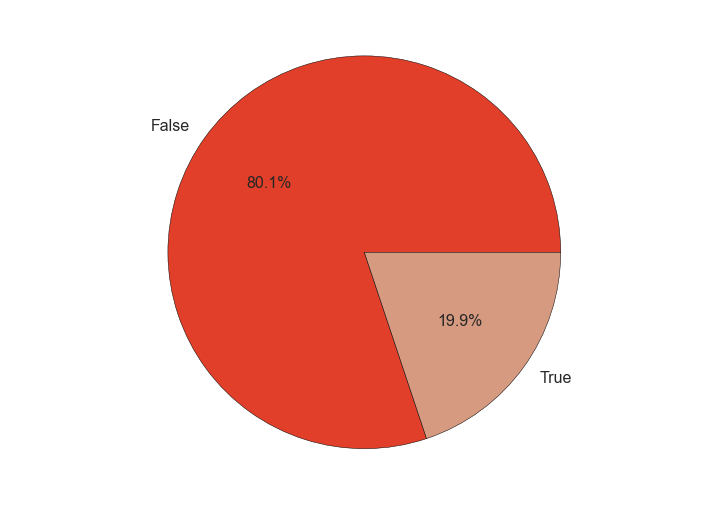

In [73]:
plt.axis('equal')
plt.pie(
    df_train.CATEGORY.value_counts().tolist(), 
    labels=['False', 'True'], 
    autopct='%1.1f%%', 
    colors=("#E13F29", "#D69A80"));

**The accuracy of a dumb classifier that classifies all the documents as False is >80%**

# Baseline classifier

## We define a trivial baseline classifier that simply look for the string 'Cardio' in the text

In [79]:
import re

def baseline_cpr_classifier(txt):
    if re.search('Cardio', txt, re.IGNORECASE):
        return True
    else:
        return False


## Testing our baseline classifier

In [90]:
Ytrue = df_test.CATEGORY.tolist()

Ypred = []

for index, row in df_test.iterrows():
    Ypred.append(baseline_cpr_classifier(row['NOTE_TEXT']))
    

### Comparing actual values to the predictions of the baseline classifier

In [91]:
dictY = {'Actual' : Ytrue, 'Predicted': Ypred}

dfY = pd.DataFrame.from_dict(dictY)

dfY.sample(20)

,Actual,Predicted
1598,False,False
6700,True,True
7296,False,False
4630,False,False
626,False,False
6721,False,False
366,False,False
870,False,False
2489,False,False
3567,False,False


## Assessing Classifier Performance

### Confusion matrix and derivative estimators

In [92]:

from ipy_table import *

confusion_matrix_binary = [
    ['', 'Predicted 0', 'Predicted 1'],
    ['Actual 0', 'True Negative', 'False Positive'],
    ['Actual 1', 'False Negative', 'True Positive']
]

make_table(confusion_matrix_binary)
apply_theme('basic_both')

,Predicted 0,Predicted 1
Actual 0,True Negative,False Positive
Actual 1,False Negative,True Positive


#### Sensitivity (Recall) or true positive rate (TPR)  $=\frac{TP}{TP+FN}$

#### Specificity (SPC) or true negative rate  $=\frac{TN}{TN+FP}$

#### Precision or positive predictive value (PPV)  $=\frac{TP}{TP+FP}$

### Confusion matrix and derivatives of the baseline classifier

In [93]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Ytrue, Ypred)

print conf_mat

print sum(conf_mat[0])


[[6226  116]
 [ 922  379]]
6342


Some code to prettify the printout of the confusion matrix in the notebook:

In [87]:
def render_confusion_matrix(ytrue, ypred):
    return pd.crosstab(pd.Series(ytrue), pd.Series(ypred), rownames=['Actual'], colnames=['Predicted'], margins=True)

In [88]:
render_confusion_matrix(Ytrue, Ypred)

Predicted,False,True,All
Actual,,,
False,6226,116,6342
True,922,379,1301
All,7148,495,7643


In [89]:
from sklearn.metrics import classification_report, accuracy_score

print
print 'Accuracy: ', accuracy_score(Ytrue, Ypred)
print
print classification_report(Ytrue, Ypred)


Accuracy:  0.864189454403

             precision    recall  f1-score   support

      False       0.87      0.98      0.92      6342
       True       0.77      0.29      0.42      1301

avg / total       0.85      0.86      0.84      7643



**Even though the accuracy is OK, the recall is misearable. Let's build a real classifier**

#Building a ML classifier

## Vectorizing textual data using Bag-of-Words (or Bag-of-Ngrams)

Our vector space is a dictionary of all the N-grams in our set of documents.

### Defining tokenizer to extract better features from the text

In [99]:
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import string

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [item for item in tokens if item.isalpha()]
    stems = stem_tokens(tokens, stemmer)
    return stems

## Vectorize the test data

In [100]:
X_train = df_train['NOTE_TEXT'].tolist()
Y_train = df_train.CATEGORY.tolist()

vectorizer = CountVectorizer(tokenizer=tokenize, ngram_range=(1,2))

wcounts = vectorizer.fit_transform(X_train)


### What is the dimentionality of our vector space?

In [102]:
wcounts

<6286x355860 sparse matrix of type '<type 'numpy.int64'>'
	with 1452481 stored elements in Compressed Sparse Row format>

** We have 6286 documents in our training set, each has 355860 features (the combination of all the uni/bi-grams)**

### The first 200 features

In [103]:
feats = vectorizer.get_feature_names()

feats[:200]

[u'a',
 u'a a',
 u'a absolut',
 u'a accuraci',
 u'a acid',
 u'a activ',
 u'a adrenalectomi',
 u'a after',
 u'a alon',
 u'a alpha',
 u'a alphasubunit',
 u'a amino',
 u'a an',
 u'a analog',
 u'a analysi',
 u'a and',
 u'a antibodi',
 u'a antigen',
 u'a antiifnalpha',
 u'a aortic',
 u'a apic',
 u'a aqueoussolubl',
 u'a are',
 u'a as',
 u'a assay',
 u'a assessmentreferr',
 u'a ata',
 u'a atmospher',
 u'a atrial',
 u'a attempt',
 u'a averag',
 u'a b',
 u'a babi',
 u'a baboon',
 u'a background',
 u'a backtoback',
 u'a bacteremia',
 u'a bacteri',
 u'a bacteriolog',
 u'a bad',
 u'a baffl',
 u'a bake',
 u'a balanc',
 u'a balloon',
 u'a ban',
 u'a band',
 u'a bandlik',
 u'a barbitur',
 u'a bard',
 u'a barium',
 u'a baromet',
 u'a baroreceptor',
 u'a barrier',
 u'a basal',
 u'a base',
 u'a baselin',
 u'a basi',
 u'a basic',
 u'a basketweav',
 u'a bath',
 u'a batteri',
 u'a bauermeist',
 u'a bcc',
 u'a bcell',
 u'a bcrabl',
 u'a bdvinfect',
 u'a bdvrelat',
 u'a bear',
 u'a beat',
 u'a becaus',
 u'a

** At this point of the workflow, there are many feature selection and engineering techniques we could apply. Some generic, some based on natural language processing and some unique to the medical domain. However, to keep it simple for now, let's move on to the classifier:**

# Naive Bayes classifier

* **Naive** conditional independence assumption: The counts of individual features (or n-grams) are independent
* **Bayes' rule** is used to calculate the conditional probabilities for each class/feature pair: 
    $P(Y|W)=\frac{P(W|Y) \cdot P(Y)}{P(W)}$

$\implies P(Y|w_{1}, w_{2}, ..., w_{N})=\frac{1}{P(W)} \cdot P(Y) \cdot \prod_{k=1}^{N}  P(w_{k}|Y)$

Since the probability of all the features is not dependent on the probability of Y and all we care about is finding the Y that is most likely, we can drop $\frac{1}{P(W)}$ and stay with:

$P(Y|w_{1}, w_{2}, ..., w_{N})=P(Y) \cdot \prod_{k=1}^{N}  P(w_{k}|Y)$

We estimate the probabilities from the training set using multinomial distribution with a smoothing factor alpha:

$P(w_{i}) = \frac{count_{i}+alpha}{overallcount_{i}+alpha \cdot N}$

<img  width="575" src="words_proba.png"/>

### Fit (aka train) a classifier with some ad-hoc parameters on the test data

In [111]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.1)

clf_nb.fit(wcounts, Y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

### Most Predictive Features

A cool feature of the Naive Bayes classifier is that it can list for us most relevant features for each class. These are the features that are most relevant to the positive documents. Some of them are trivial English words, that will also appear in the list of features relevant to the Negative documents. However - we also see some domain specific features, such as **arteri** and ** coronari** :

In [112]:
pf = [(clf_nb.feature_log_prob_[1, i], feats[i]) for i in range(len(feats))]
pf.sort(reverse=True)
for p in pf[:25]:
    print 'Positive word %.2f: %s' % (p[0], p[1])

Positive word -3.82: the
Positive word -3.84: of
Positive word -4.15: in
Positive word -4.18: and
Positive word -4.77: to
Positive word -4.81: with
Positive word -4.86: patient
Positive word -4.89: a
Positive word -5.14: wa
Positive word -5.41: were
Positive word -5.57: of the
Positive word -5.58: for
Positive word -5.71: than
Positive word -5.73: in the
Positive word -5.85: by
Positive word -5.87: or
Positive word -5.96: arteri
Positive word -6.00: patient with
Positive word -6.01: that
Positive word -6.04: is
Positive word -6.09: after
Positive word -6.11: group
Positive word -6.15: coronari
Positive word -6.16: less
Positive word -6.19: from


## Test the classifier with the test data


In [117]:
# Read the data from pandas dataframe to an array
X_test = df_test['NOTE_TEXT'].tolist()
Y_test = df_test.CATEGORY.tolist()

# Convert the text to arrays of numbers
counts_test = vectorizer.transform(X_test)

In [118]:
counts_test

<7643x355860 sparse matrix of type '<type 'numpy.int64'>'
	with 1468293 stored elements in Compressed Sparse Row format>

**We have 7643 documents in our test set, each has 355860 features - exactly the same features we set while processing the training set of course.**

In [119]:
# Predict the values of the test set
predictions = clf_nb.predict(counts_test)

In [120]:
# Look at the first 20 predictions
predictions[:20]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False], dtype=bool)

### Confusion matrix and derivatives of the classifier

In [122]:
render_confusion_matrix(Y_test, predictions)

Predicted,False,True,All
Actual,,,
False,6064,278,6342
True,292,1009,1301
All,6356,1287,7643


In [124]:
print
print 'Accuracy: ', accuracy_score(Y_test, predictions)
print
print classification_report(Y_test, predictions)



Accuracy:  0.92542195473

             precision    recall  f1-score   support

      False       0.95      0.96      0.96      6342
       True       0.78      0.78      0.78      1301

avg / total       0.93      0.93      0.93      7643



**As expected we improved the accuracy compared to the baseline classifier, and dramatically improved the recall on the positive documents - from 29% to 78%.**

**Before we move on to optimize the classifier, let's look at some other interesting output type of Naive Bayes - some insightful output besides the predictions on the test data**

## Get the indices of the elements that with wrong predictions

In [138]:
iwrong_predictions = [i for i,v in enumerate(zip(Y_test, predictions)) if v[0] != v[1]]

iwrong_predictions[:20]

[13,
 24,
 25,
 41,
 52,
 80,
 174,
 246,
 353,
 416,
 467,
 731,
 991,
 1005,
 1038,
 1047,
 1068,
 1120,
 1140,
 1176]

##  Probabilities of a particular classification

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods of `MultinomialNB` compute these probabilities. 

In [139]:
proba = clf_nb.predict_proba(counts_test)
log_proba = clf_nb.predict_log_proba(counts_test)

In [140]:
proba[:10]

array([[  1.00000000e+000,   2.94055710e-037],
       [  1.00000000e+000,   2.56434674e-112],
       [  9.99999993e-001,   7.36050607e-009],
       [  1.00000000e+000,   3.67672356e-048],
       [  1.00000000e+000,   2.17669993e-030],
       [  1.00000000e+000,   1.25863592e-081],
       [  1.00000000e+000,   2.47597297e-173],
       [  1.00000000e+000,   2.14988957e-053],
       [  1.00000000e+000,   5.70562372e-108],
       [  1.00000000e+000,   4.42691208e-041]])

The output of `clf_nb.predict_proba(counts_test)` is a `(N example, 2)` array. The first column gives the probability $P(Y=0)$ or $P(False)$, and the second gives $P(Y=1)$ or $P(True)$.

**Commonly it is more comfortable to work with the log values of the probabilities - the results of `clf_nb.predict_log_proba`**

## Calculate and plot the differences between the True and False probabilities

In [141]:
diff_prob = proba[:,1] - proba[:,0]
diff_log_proba = log_proba[:,1] - log_proba[:,0]

In [142]:
print 'diff_prob:\n'
print 'mean:',np.mean(diff_prob)
print 'std:', np.std(diff_prob)

print '\ndiff_log_prob:\n'
print 'mean:', np.mean(diff_log_proba)
print 'std:', np.std(diff_log_proba)


diff_prob:

mean: -0.662949326315
std: 0.746432184454

diff_log_prob:

mean: -94.3395679123
std: 150.446111867


In [143]:
diff_log_proba[-10:]

array([-120.99198123, -105.33481755,  -45.92763286, -115.47860148,
       -126.40541505, -158.90170764,   30.44267742,  -27.78738764,
        404.37342916, -157.70848569])

### Distribution of the predictions on the test set, as function of the difference between the True/False log probabilities

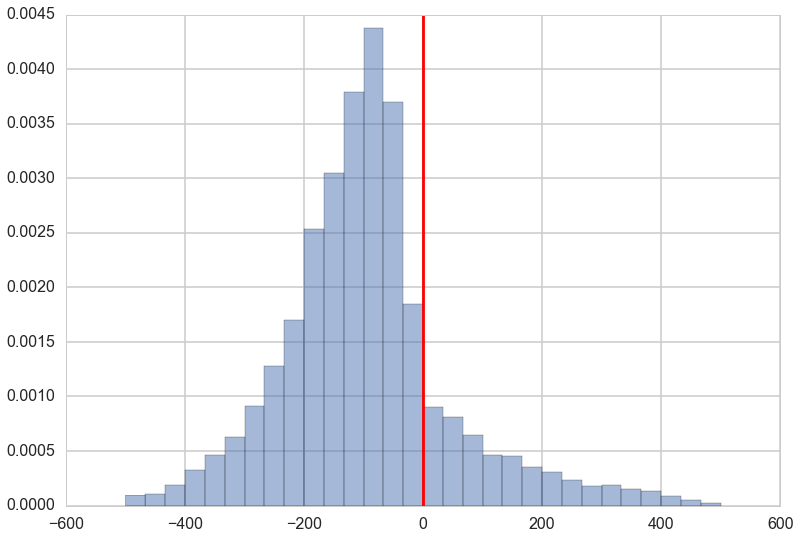

In [149]:
# Plot  histogram.
plt.hist(diff_log_proba, range=[-500, 500], bins=30, normed=True, alpha=0.5)
plt.axvline(0, color='r')


## Another view on the distribution of the prediction scores of our classifier

### Divide the test set into 2 sets - True (blue) / False(red) - and plot them in a scatter plot

In [151]:
pospts = [v[1] for i,v in enumerate(zip(Y_test, diff_log_proba)) if v[0] == 1]
negpts = [v[1] for i,v in enumerate(zip(Y_test, diff_log_proba)) if v[0] == 0]

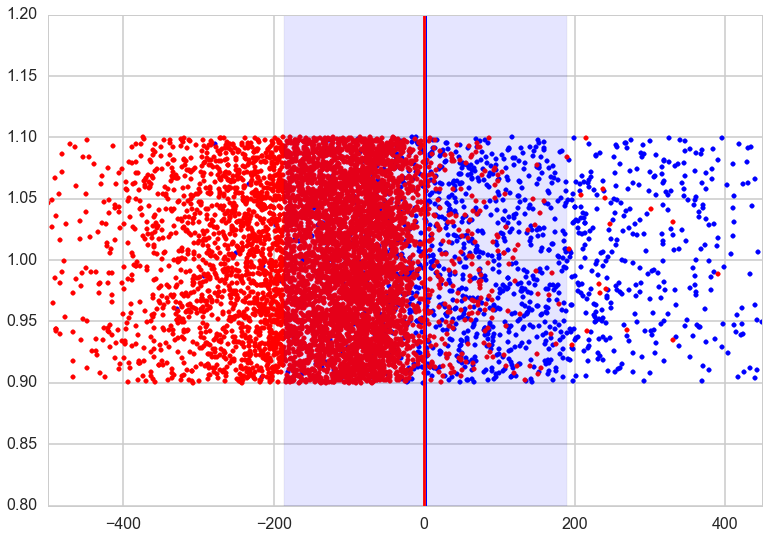

In [202]:
import random 

plt.scatter(
    pospts, 
    np.random.uniform(0.9, 1.1, len(pospts)),
    color='blue')

plt.scatter(
    negpts, 
    np.random.uniform(0.9, 1.1, len(negpts)),
    color='red')

plt.xlim(-500, 450)

plt.ylim(0.8, 1.2)

plt.axvline(0, color='r')

values = np.array(diff_log_proba[iwrong_predictions])

plt.axvspan(
    np.mean(values)-2*np.std(values),
    np.mean(values)+2*np.std(values), 
    facecolor='b', alpha=0.1)

plt.axvline(np.mean(values), linewidth=1);

## Optimizing the classification pipeline

### Scorer function

When optimizing parameters for classification pipeline we can write or define our own scoring function. The optimizing routine `GridSearchCV` which runs a **brute force parameter search**, will select the parameters that got the **highest** score.

### What do we want to optimize exactly?

When classifing medical documents, we sometimes want to **maximize sensitivity** (recall) while keeping specificity and accuracy in check. In other words - the sensitivity is our **target optimization parameter**. To maximize sensitivity, I'll define a scorer function that returns the recall score.

In [199]:
from sklearn.metrics import recall_score, make_scorer

# Define scorer function that returns the recall score
recall_scorer = make_scorer(recall_score)

Now we build a full pipeline and use the `GridSearchCV` sklearn utility to fit the best paramaters for the pipeline. Normally I use longer lists of parameters, but that takes hours to run.

NOTE - we will use `GridSearchCV` default 3-fold cross-validation. Other cross-validation schemes can be defined if needed. 

In [201]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('clf', MultinomialNB())
])

# Define some possible parameters for feature extraction and for the classifier
parameters = {
    'vect__max_features': (20000, 30000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__alpha': (0.05, 0.1, 0.2)
}

# find the best parameters for both the feature extraction and the
# classifier, based on the scorer function we defined
grid_search = GridSearchCV(pipeline, parameters, verbose=1, scoring=recall_scorer)

grid_search.fit(df_train['NOTE_TEXT'].tolist(), df_train.CATEGORY.tolist())

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   17.2s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 10.9min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...28>,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'vect__ngram_range': ((1, 1), (1, 2)), 'vect__max_features': (20000, 30000), 'clf__alpha': (0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(recall_score), verbose=1)

In [203]:
print("Best parameters set found on development set:")
print
print(grid_search.best_params_)

Best parameters set found on development set:

{'vect__ngram_range': (1, 1), 'vect__max_features': 30000, 'clf__alpha': 0.2}


## Try the optimized classifier on the test set and output the performance parameters

In [204]:
# Use the optimal classifier to make predictions on the test set

opt_predictions = grid_search.predict(df_test['NOTE_TEXT'].tolist())

In [205]:
render_confusion_matrix(df_test.CATEGORY.tolist(), opt_predictions)

Predicted,False,True,All
Actual,,,
False,5928,414,6342
True,240,1061,1301
All,6168,1475,7643


In [206]:
print
print 'Accuracy: ', accuracy_score(df_test.CATEGORY.tolist(), opt_predictions)
print
print classification_report(df_test.CATEGORY.tolist(), opt_predictions)



Accuracy:  0.914431505953

             precision    recall  f1-score   support

      False       0.96      0.93      0.95      6342
       True       0.72      0.82      0.76      1301

avg / total       0.92      0.91      0.92      7643



Comparing the performance of the optimized classifier to the performance of the the classifier with the ad-hoc parameters shows, that while the accuracy of the optimized classifier is a bit lower (91% compared to 92%), the sensitivity for True documents, which is our target performance parameter, increased from 78% to 82%.